In [1]:
import random
import numpy as np
import pandas as pd
import time
import re
import datetime
import os
import matplotlib.pyplot as plt
import gensim

In [2]:
import nltk
from nltk.tokenize import sent_tokenize

In [3]:
df = pd.read_excel('data/Jul21_3379_articles.xlsx',index_col=0)
df = df.reset_index()
print(len(df))
df.head()

3379


,index,newsOutlet,dateSeen,url,title,language,sourceCountry,text,category,textCharCt
0,0,apnews.com,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318
1,1,apnews.com,2021-10-12 07:00:00,https://apnews.com/cdfd9b277f6bade5697e0427429...,Blinken reaffirms US support for Ukraine amid ...,English,United States,"KYIV, Ukraine (AP) — U.S. Secretary of State A...",western,6032
2,2,apnews.com,2021-10-11 07:00:00,https://apnews.com/90b50e622cefcbaeba96cb5e716...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318
3,3,apnews.com,2021-10-06 07:00:00,https://apnews.com/0b689a7baaac58603e4d7453aa5...,Ukraine Holocaust center names Nazi Babi Yar k...,English,United States,"KYIV, Ukraine (AP) — The presidents of Ukraine...",western,3646
4,4,apnews.com,2021-10-13 07:00:00,https://apnews.com/89d2455274aad5fe166445a5f82...,Ukraine separatist areas overwhelmed by soarin...,English,United States,"KYIV, Ukraine (AP) — The Russia-backed separat...",western,2184


In [4]:
# df = df[df['newsOutlet'] != 'bbc.co.uk']/

In [5]:
# process texts
def tm_tokenize(txt):
    word_corrections = [
    ('said',''),
    ('Reuters',''),
    ('REUTERS',''),
    ('Thomson',''),
    ('AP', ''),
    ('Sputnik',''),
    ('TASS',''),
    ('BBC',''),
    ('Kiev ','Kyiv '),
    ('Lugansk','Luhansk'),
    ('Donbas','Donbass'),
    ('U.S.','US'),
    ('United States','US'),
    (''' We'd love to get your feedback at radio@sputniknews.com''',''),
    ('radio@sputniknews.com',''),
    ('Aleksandr', 'Alexander')
    ]
    takeoutif = [
        'This story has been corrected to show',
        'contributed to this report',
        'All rights reserved',
        'not responsible for the material quoted in these press',
        'Follow all AP stories',
        'https',
        'dedicated page',
        'Follow AP’s coverage',
        '©',
        'This video can not be played',
        '© 2022 Reuters.'
        'contributed reporting',
        'Please include your name, age and location with any submission.',
        'See here for',
        'contributed.',
        'reported from',
        'reaching billions of people worldwide every day',
        'quotes delayed a minimum',
        'contributed to this story.',
        'pic.twitter.com',
        'Screen for heightened risk individual and entities globally to help uncover hidden risks in business relationships and human networks.',
        'Browse an unrivalled portfolio of',
        'Access unmatched financial',
        'Reuters',
        'Build the strongest argument relying on',
        'The most comprehensive solution to manage all',
        'Access unmatched financial data',
        'The industry leader for online information for tax'
        ]
    for a, b in word_corrections:
        txt = txt.replace(a, b)
    for string in takeoutif:
        if string in txt:
            return None
    if not txt[0].isalpha() and txt[0] not in ['"',"'",'“']:
        return None
    if len(txt) <= 50:
        return None
    return txt

In [6]:
docs = []
texts = []

article2sents = dict()

listBySent = []
records = df.to_dict('records')
totalSents = 0
validSents = 0
for i, rec in enumerate(records):
    if i % 500 == 0:
        print(f'{i}/{len(records)} articles processed')
    rec_text = rec['text']
    if isinstance(rec_text, str):
        sents = sent_tokenize(rec_text)
        validSentsinDoc = []
        sentIdx = 0
    
        for text in sents:
            sentRec = dict()
            sentRec['index'] = i
            sentRec['newsOutlet'] = rec['newsOutlet']
            sentRec['category'] = rec['category']
            sentRec['dateSeen'] = rec['dateSeen']
            sentRec['url'] = rec['url']
            sentRec['title'] = rec['title']
            sentRec['language'] = rec['language']
            sentRec['sourceCountry'] = rec['sourceCountry']
            
            cleaned_text = tm_tokenize(text)
            totalSents += 1
            if cleaned_text == None:
                continue
            else:
                docs.append(cleaned_text)
                texts.append(text)
                sentRec['sentText'] = cleaned_text
                sentRec['sentIndexInText'] = sentIdx
                sentRec['articleIndex'] = i
                listBySent.append(sentRec)
                validSentsinDoc.append(text)
                validSents += 1
                sentIdx += 1
                
        article2sents[i] = validSentsinDoc
        
print(f'\n{validSents}/{totalSents} sentences valid.\n')
print(len(docs),'docs processed successfully!')

0/3379 articles processed
500/3379 articles processed
1000/3379 articles processed
1500/3379 articles processed
2000/3379 articles processed
2500/3379 articles processed
3000/3379 articles processed

55043/66347 sentences valid.

55043 docs processed successfully!


In [29]:
%%time
sentenceDf = pd.read_excel('data/topic_model_data/fullSentTopics_7-31-2.xlsx',index_col=0)
sentenceDf.head()

CPU times: user 11.8 s, sys: 540 ms, total: 12.3 s
Wall time: 13.8 s


,index,newsOutlet,category,dateSeen,url,title,language,sourceCountry,sentText,sentIndexInText,sentTopicID
0,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,0,-1
1,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,Acting on a request from Ukraine for help with...,1,-1
2,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,The topic will be discussed during a summit Tu...,2,-1
3,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,The results of the mission have yet to be anal...,3,24
4,0,apnews.com,western,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,One official said the EU’s political and secur...,4,-1


## N-gram analysis

In [8]:
import itertools
import stanza

In [31]:
stanza.download('en')

2022-07-31 18:05:04 INFO: Downloading default packages for language: en (English)...
2022-07-31 18:05:06 INFO: File exists: /Users/paigelee/stanza_resources/en/default.zip.
2022-07-31 18:05:10 INFO: Finished downloading models and saved to /Users/paigelee/stanza_resources.


In [32]:
nlp = stanza.Pipeline('en')

2022-07-31 18:05:11 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2022-07-31 18:05:11 INFO: Use device: cpu
2022-07-31 18:05:11 INFO: Loading: tokenize
2022-07-31 18:05:12 INFO: Loading: pos
2022-07-31 18:05:12 INFO: Loading: lemma
2022-07-31 18:05:12 INFO: Loading: depparse
2022-07-31 18:05:13 INFO: Loading: sentiment
2022-07-31 18:05:13 INFO: Loading: ner
2022-07-31 18:05:14 INFO: Done loading processors!


In [33]:
import nltk
from nltk.corpus import stopwords

engStopwords = set(stopwords.words('english'))

In [ ]:
jsonDict = dict()

In [42]:
%%time
# get cooccurrence connections
thresh = 5
n = 4

allSentRecords = sentenceDf.to_dict('records')

for cat in ['western','russian']:
    networkJson = dict()
    networkJson['nodes'] = []
    networkJson['links'] = []

    curatedNodes = set()
    linkCounter = dict()
    keywordCounter = dict()

    windowList = []
    records = []
    for d in allSentRecords:
        if d['category'] == cat and d['sentTopicID'] != -1:
            records.append(d)
    for i, rec in enumerate(records):
        if i % 1000 == 0:
            print(f'{i}/{len(records)} recs parsed by NLP')
        docText = rec['sentText']
        nlpdoc = nlp(docText)
        wordList = [w for w in nlpdoc.iter_words() if w.text.isalpha() and w.text.lower() not in engStopwords]
        for windowIdx in range(len(wordList) // n + len(wordList) % n):
            startIdx = windowIdx
            endIdx = windowIdx+random.choice(list(range(1,n+1)))
            wordWindow = wordList[startIdx:endIdx]
            tokens = []
            for wordToken in wordWindow:
                formattedToken = wordToken.lemma.lower()
                if formattedToken in engStopwords:
                    continue
                tokens.append(formattedToken)
            windowList.append(tokens)
        for t1 in [w.lemma.lower() for w in wordList]:
            keywordCounter.setdefault(t1, 0)
            keywordCounter[t1] += 1
    print('\tdone nlping docs')
    sufficientNodes = set()
    for key in keywordCounter:
        if keywordCounter[key] >= thresh:
            sufficientNodes.add(key)
    print('\tfound sufficient recs')
    for tokens in windowList:
        s = set(tokens)
        subsets = [tuple(i) for i in itertools.combinations(s, 2)]
        for t1, t2 in subsets:
            if t1 != t2 and t1 in sufficientNodes and t2 in sufficientNodes:
                label = '_'.join(sorted([t1, t2]))
                linkCounter.setdefault(label, 0)
                linkCounter[label] += 1
    print('\tgot linked tokens')
    node2id = dict()
    for i, node in enumerate(sufficientNodes):
        networkJson['nodes'].append({
            'id' : node,
            'occurrences' : keywordCounter[node]
        })
        node2id[node] = i

    for label in linkCounter:
        source, target = label.split('_')
        networkJson['links'].append({
            'source' : node2id[source],
            'target' : node2id[target],
            'value' : linkCounter[label]
        })
    
    jsonDict[cat] = networkJson
    
    with open(f'data/{cat}ngramNet{n}.json', 'w', encoding ='ascii') as json_file:
        json.dump(networkJson, json_file, ensure_ascii = True)
    print('\twrote json')

0/18530 recs parsed by NLP
1000/18530 recs parsed by NLP
2000/18530 recs parsed by NLP
3000/18530 recs parsed by NLP
4000/18530 recs parsed by NLP
5000/18530 recs parsed by NLP
6000/18530 recs parsed by NLP
7000/18530 recs parsed by NLP
8000/18530 recs parsed by NLP
9000/18530 recs parsed by NLP
10000/18530 recs parsed by NLP
11000/18530 recs parsed by NLP
12000/18530 recs parsed by NLP
13000/18530 recs parsed by NLP
14000/18530 recs parsed by NLP
15000/18530 recs parsed by NLP
16000/18530 recs parsed by NLP
17000/18530 recs parsed by NLP
18000/18530 recs parsed by NLP
	done nlping docs
	found sufficient recs
	got linked tokens
	wrote json
0/22646 recs parsed by NLP
1000/22646 recs parsed by NLP
2000/22646 recs parsed by NLP
3000/22646 recs parsed by NLP
4000/22646 recs parsed by NLP
5000/22646 recs parsed by NLP
6000/22646 recs parsed by NLP
7000/22646 recs parsed by NLP
8000/22646 recs parsed by NLP
9000/22646 recs parsed by NLP
10000/22646 recs parsed by NLP
11000/22646 recs parsed 

In [36]:
import json

In [38]:
# with open(f'data/russianngramNet.json', 'w', encoding ='ascii') as json_file:
#         json.dump(jsonDict['russian'], json_file, ensure_ascii = True)

## Counts across outlets and categories

In [264]:
sentenceDf['category'].value_counts()

russian    30039
western    25004
Name: category, dtype: int64

In [265]:
sentenceDf['newsOutlet'].value_counts()

sputniknews.com    15418
tass.com           14621
apnews.com         13349
bbc.co.uk           7586
reuters.com         4069
Name: newsOutlet, dtype: int64

## Time frame

### Sentences

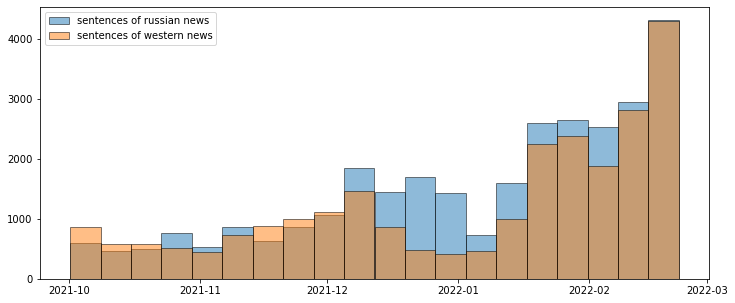

In [266]:
from matplotlib import pyplot as plt

x = sentenceDf[sentenceDf['category'] == 'russian']['dateSeen']
y = sentenceDf[sentenceDf['category'] == 'western']['dateSeen']

bins = 20

plt.hist(x, bins=bins, alpha=0.5, label='sentences of russian news', edgecolor='black')
plt.hist(y, bins=bins, alpha=0.5, label='sentences of western news', edgecolor='black')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(12, 5)
# fig.savefig('test2png.png', dpi=100)
plt.show()

### Articles

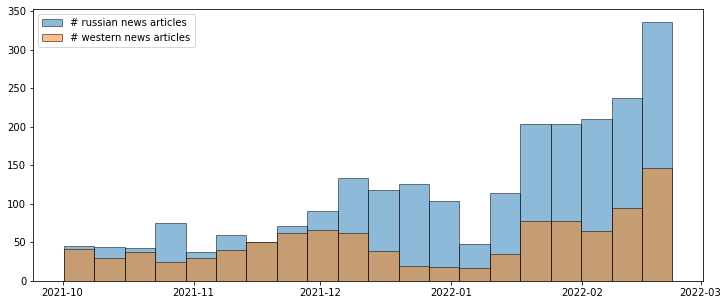

In [253]:
from matplotlib import pyplot as plt

x = df[df['category'] == 'russian']['dateSeen']
y = df[df['category'] == 'western']['dateSeen']

bins = 20

plt.hist(x, bins=bins, alpha=0.5, label='# russian news articles', edgecolor='black')
plt.hist(y, bins=bins, alpha=0.5, label='# western news articles', edgecolor='black')
plt.legend(loc='upper left')
fig = plt.gcf()
fig.set_size_inches(12, 5)
# fig.savefig('test2png.png', dpi=100)
plt.show()

## Sentence length

### Western vs. Russian

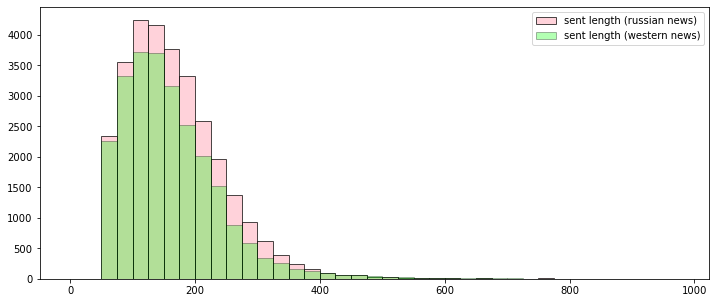

In [254]:
x = sentenceDf[sentenceDf['category'] == 'russian']['sentText'].apply(lambda x: len(x))
y = sentenceDf[sentenceDf['category'] == 'western']['sentText'].apply(lambda x: len(x))

bins = list(range(0,1000,25))
plt.hist(x, bins=bins, alpha=0.7, label='sent length (russian news)', edgecolor='black', color='pink')
plt.hist(y, bins=bins, alpha=0.3, label='sent length (western news)', edgecolor='black', color='lime')
plt.legend(loc='upper right')
fig = plt.gcf()
fig.set_size_inches(12, 5)
# fig.savefig('test2png.png', dpi=100)
plt.show()

In [255]:
print('mean sent length russian:', x.mean())
print('mean sent length western:', y.mean())

mean sent length russian: 167.2152320085214
mean sent length western: 161.3896176611742


### All outlets

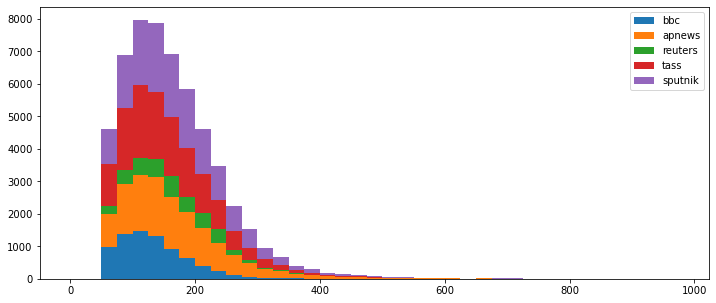

In [256]:
a = sentenceDf[sentenceDf['newsOutlet'] == 'apnews.com']['sentText'].apply(lambda x: len(x))
r = sentenceDf[sentenceDf['newsOutlet'] == 'reuters.com']['sentText'].apply(lambda x: len(x))
t = sentenceDf[sentenceDf['newsOutlet'] == 'tass.com']['sentText'].apply(lambda x: len(x))
s = sentenceDf[sentenceDf['newsOutlet'] == 'sputniknews.com']['sentText'].apply(lambda x: len(x))
b = sentenceDf[sentenceDf['newsOutlet'] == 'bbc.co.uk']['sentText'].apply(lambda x: len(x))

bins = list(range(0,1000,25))
plt.hist([b, a,r,t,s], bins=bins, label=['bbc','apnews','reuters','tass','sputnik'], stacked=True, histtype='bar')
# plt.hist(a, bins=bins, alpha=0.6, label='sent length (apnews)', edgecolor='black', color='red')
# plt.hist(r, bins=bins, alpha=0.6, label='sent length (reuters)', edgecolor='black', color='orange')
# plt.hist(t, bins=bins, alpha=0.6, label='sent length (tass)', edgecolor='black', color='green')
# plt.hist(s, bins=bins, alpha=0.6, label='sent length (sputnik)', edgecolor='black', color='blue')
plt.legend(loc='upper right')
fig = plt.gcf()
fig.set_size_inches(12, 5)
# fig.savefig('test2png.png', dpi=100)
plt.show()

In [257]:
print('mean sent length bbc:', b.mean())
print('mean sent length apnews:', a.mean())
print('mean sent length reuters:', r.mean())
print('mean sent length tass:', t.mean())
print('mean sent length sputnik:', s.mean())

mean sent length bbc: 132.12997627208014
mean sent length apnews: 177.08592403925388
mean sent length reuters: 164.44531826001474
mean sent length tass: 159.73845838177962
mean sent length sputnik: 174.3041307308216


### Readability

In [273]:
# pip install py-readability-metrics

In [268]:
from readability import Readability

In [291]:
textLevels = []
shortCt = 0
for rec in records:
    text = rec['text']
    try:
        r = Readability(text)
        fk = r.flesch_kincaid()
        # print(fk.score)
        # print(fk.grade_level)
        textLevels.append({
            'fk' : fk.score,
            'text' : text,
            'outlet' : rec['newsOutlet'],
            'category' : rec['category']
        })
    except:
        shortCt += 1

In [275]:
shortCt

72

In [292]:
fkDf = pd.DataFrame.from_records(textLevels)
fkDf.head()

,fk,text,outlet,category
0,15.019373,BRUSSELS (AP) — The European Union is consider...,apnews.com,western
1,16.855053,"KYIV, Ukraine (AP) — U.S. Secretary of State A...",apnews.com,western
2,15.019373,BRUSSELS (AP) — The European Union is consider...,apnews.com,western
3,11.888767,"KYIV, Ukraine (AP) — The presidents of Ukraine...",apnews.com,western
4,14.848945,"KYIV, Ukraine (AP) — The Russia-backed separat...",apnews.com,western


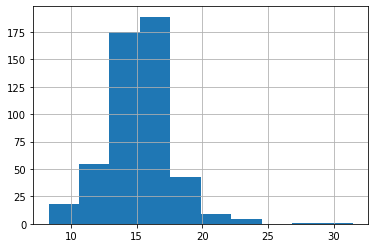

In [ ]:
hist = a.hist(bins=10)

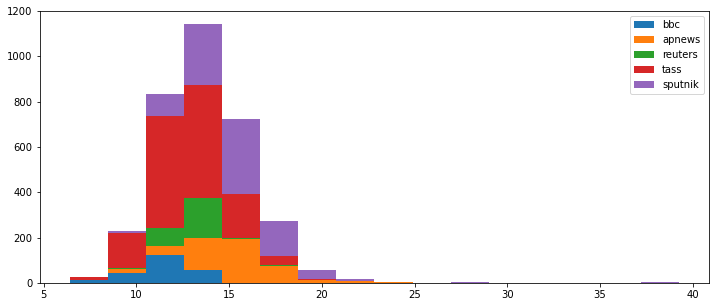

In [290]:
a = fkDf[fkDf['outlet'] == 'apnews.com']['fk']
r = fkDf[fkDf['outlet'] == 'reuters.com']['fk']
t = fkDf[fkDf['outlet'] == 'tass.com']['fk']
s = fkDf[fkDf['outlet'] == 'sputniknews.com']['fk']
b = fkDf[fkDf['outlet'] == 'bbc.co.uk']['fk']

bins = list(range(0,30,6))
plt.hist([b, a,r,t,s], bins=16, label=['bbc','apnews','reuters','tass','sputnik'], stacked=True, histtype='bar')

plt.legend(loc='upper right')
fig = plt.gcf()
fig.set_size_inches(12, 5)
# fig.savefig('test2png.png', dpi=100)
plt.show()

In [282]:
print('mean fk bbc:', b.mean())
print('mean fk apnews:', a.mean())
print('mean fk reuters:', r.mean())
print('mean fk tass:', t.mean())
print('mean fk sputnik:', s.mean())

mean fk bbc: 11.47135993359858
mean fk apnews: 15.169216671648
mean fk reuters: 12.96815375988665
mean fk tass: 12.819399464104567
mean fk sputnik: 15.281507697700203


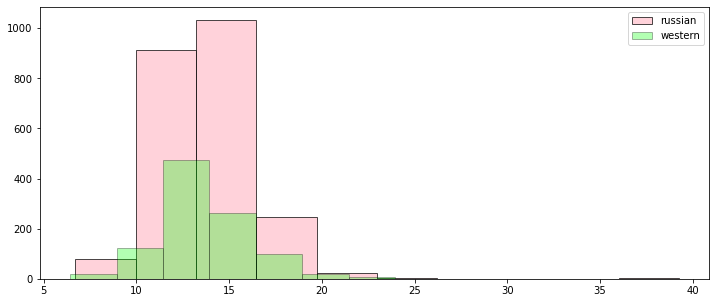

In [293]:
wes = fkDf[fkDf['category'] == 'western']['fk']
rus = fkDf[fkDf['category'] == 'russian']['fk']

bins=10
plt.hist(rus, bins=bins, alpha=0.7, label='russian', edgecolor='black', color='pink')
plt.hist(wes, bins=bins, alpha=0.3, label='western', edgecolor='black', color='lime')
plt.legend(loc='upper right')
fig = plt.gcf()
fig.set_size_inches(12, 5)
# fig.savefig('test2png.png', dpi=100)
plt.show()

In [296]:
print('mean fk rus:', rus.describe())
print('mean fk wes:', wes.describe())

mean fk rus: count    2303.000000
mean       13.797614
std         2.526934
min         6.702714
25%        12.121013
50%        13.665428
75%        15.244354
max        39.255363
Name: fk, dtype: float64
mean fk wes: count    1004.000000
mean       13.702994
std         2.504207
min         6.424552
25%        12.203290
50%        13.371616
75%        15.242227
max        31.457714
Name: fk, dtype: float64
